In [45]:
import os
import shutil
from tqdm import tqdm
from random import shuffle
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from glob import glob

from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications.efficientnet import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
import albumentations as A

import torch

from sklearn.model_selection import train_test_split

# Подготовка данных

In [80]:
princess_data = pd.concat([pd.read_csv('data/Princess_400/objects.csv'), 
                           pd.read_csv('data/Princess_400/objects_extra.csv')], ignore_index=True)

princess_data['path'] = princess_data.id.apply(lambda x: 'data/Princess_400/'+x)

In [81]:
def get_width(path):
    image = cv2.imread(path)
    try:
        return image.shape[1]
    except:
        return np.nan

def get_height(path):
    image = cv2.imread(path)
    try:
        return image.shape[0]
    except:
        return np.nan

In [82]:
widths = []
heights = []

for path in tqdm(princess_data.path):
    widths.append(get_width(path))
    heights.append(get_height(path))
    
princess_data['width'] = widths
princess_data['height'] = heights

100%|██████████| 455/455 [00:26<00:00, 17.01it/s]


In [83]:
princess_data['x_c'] = princess_data.bbox.apply(lambda x: ( (float(x.split(' ')[2]) + float(x.split(' ')[0])) / 2 ) )
princess_data['x_c'] = (princess_data['x_c'] / princess_data['width']).apply(lambda x: max(0, min(1, x)))

princess_data['y_c'] = princess_data.bbox.apply(lambda x: ( (float(x.split(' ')[3]) + float(x.split(' ')[1])) / 2 ) )
princess_data['y_c'] = (princess_data['y_c'] / princess_data['height']).apply(lambda x: max(0, min(1, x)))

princess_data['width_box'] = princess_data.bbox.apply( lambda x: (float(x.split(' ')[2]) - float(x.split(' ')[0])) )
princess_data['width_box'] = (princess_data['width_box'] / princess_data['width']).apply(lambda x: max(0, min(1, x)))

princess_data['height_box'] = princess_data.bbox.apply(lambda x: (float(x.split(' ')[3]) - float(x.split(' ')[1])) )
princess_data['height_box'] = (princess_data['height_box'] / princess_data['height']).apply(lambda x: max(0, min(1, x)))

princess_data['yolo'] = princess_data.apply(lambda x: '{} '.format(0) + 
                                        ' '.join([str(round(s, 4)) for s in x[-4:]]), axis=1)

In [84]:
other_data = pd.read_csv('train.csv')
other_data = other_data[(other_data.yolo.notnull())&(other_data['class'] == 'Tiger')]

In [85]:
princess_data = princess_data[princess_data.width.notnull()].reset_index(drop=True)
princess_data = princess_data[other_data.columns]

In [86]:
princess_data['is_princess'] = 1
other_data['is_princess'] = 0

princess_data = pd.concat([princess_data, other_data], ignore_index=True)

In [87]:
princess_data = princess_data[~princess_data.path.isin(list(princess_data.groupby('path') \
                                                            .id.count().sort_values().tail(37).index))]

In [88]:
princess_data = princess_data.reset_index(drop=True)

In [90]:
# for path in tqdm(princess_data.path.iloc[:]):
        
#     X = cv2.imread(path)
    
#     x_c, y_c, width, height = [float(x) for x in princess_data[princess_data.path == path].yolo.iloc[0].split(' ')[1:]] 
    
#     x_c *= X.shape[1]
#     width = (width * X.shape[1]) / 2
#     y_c *= X.shape[0]
#     height = (height * X.shape[0]) / 2
    
#     X = X[ max(0, int(y_c-height)):int(y_c+height), 
#            max(0, int(x_c-width)):int(x_c+width), : ] 
    
#     X = cv2.resize(X, (256, 256))
        

# Нейросетевой подход

Не работает

## datagen

In [205]:
img1 = cv2.imread(princess_data.path.iloc[12])

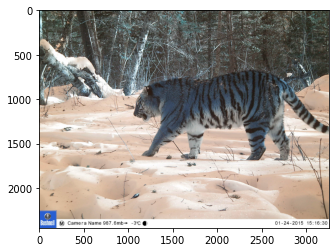

In [206]:
plt.imshow(img1)

In [215]:
for path in tqdm(princess_data[princess_data.is_princess == 0].path):
    
    img2 = cv2.imread(path)
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    
    picture1_norm = img1/np.sqrt(np.sum(img1**2))
    
    picture2_norm = img2/np.sqrt(np.sum(img2**2))
    
    if np.sum(picture2_norm*picture1_norm) > 0.9999:
        break

  0%|          | 0/3459 [00:00<?, ?it/s]


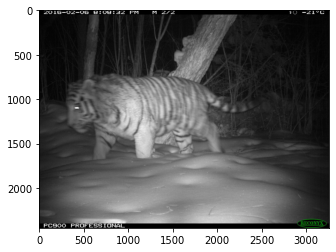

In [216]:
plt.imshow(img2)

In [161]:
def augment_image(image):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ])
    augmented = aug(image=image)
    return augmented['image'] 

In [162]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 augment=True,
                 batch_size=8,
                 input_shape=(256, 256, 3),
                 shuffle=True):
        
        self.df = df
        self.paths = df.path.values
        self.labels = df.is_princess.values
        self.augment = augment
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.paths)
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    def __load_data(self, paths, labels):
    
        X_batch = []
        y_batch = []
        
        for path in paths:
            
            X = cv2.cvtColor(cv2.imread(path).copy(), cv2.COLOR_BGR2RGB)
            
            x_c, y_c, width, height = [float(x) for x in self.df[self.df.path == path].yolo.iloc[0].split(' ')[1:]] 
            
            x_c *= X.shape[1]
            width = (width * X.shape[1]) / 2
            y_c *= X.shape[0]
            height = (height * X.shape[0]) / 2
            
            X = X[ max(0, int(y_c-height)):int(y_c+height), 
                   max(0, int(x_c-width)):int(x_c+width), : ] 
            
            X = cv2.resize(X, (self.input_shape[0], self.input_shape[1]))
            
            if self.augment:
                X = augment_image(X)
            
            X2 = X / 255.
            
            X_batch.append(X2)
        
        for label in labels:
            y_batch.append(label)
            
        return np.array(X_batch, dtype=float), np.array(y_batch, dtype=float)
    
    
    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__load_data([self.paths[i] for i in indexes],
                                [self.labels[i] for i in indexes])        
        
        return X, y
    
    
    def __len__(self):
        
        return int(np.floor(len(self.paths) / self.batch_size))

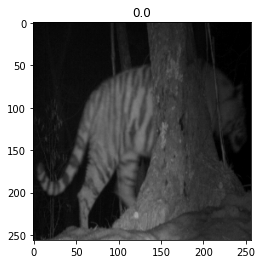

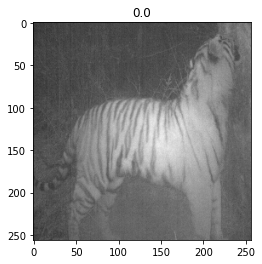

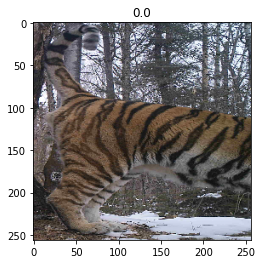

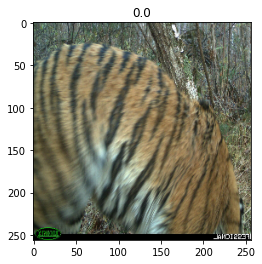

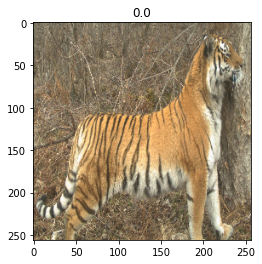

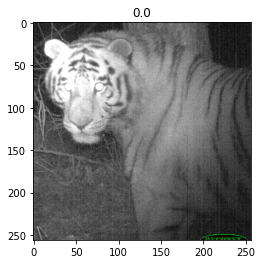

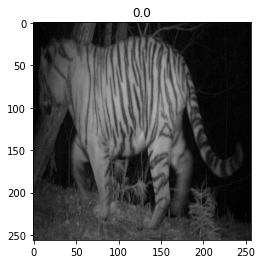

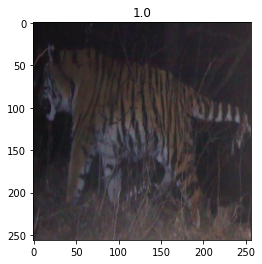

In [163]:
traingen = CustomDataGen(princess_data, batch_size=8, input_shape=(256, 256, 3))

for x, y in traingen:
    break
    
for xx, yy in zip(x, y):
    plt.imshow(xx)
    plt.title(yy)
    plt.show()

## model

In [189]:
def create_model(input_shape=(256, 256, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, classes=1)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(1, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [217]:
K.clear_session()

model = create_model((128, 128, 3))

metrics = [
    'Recall',
    'Precision'
]

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=metrics)

In [218]:
train_df, val_df = train_test_split(princess_data, test_size=0.15, 
                                    stratify=princess_data['is_princess'])

traingen = CustomDataGen(train_df, input_shape=(128, 128, 3), batch_size=16)
valgen = CustomDataGen(val_df, input_shape=(128, 128, 3), batch_size=16, augment=False)

In [219]:
checkpoint_path = 'models/princess_classify/model_256.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, 
                    save_best_only=True, save_weights_only=False)
]

In [220]:
results = model.fit(traingen, validation_data=valgen,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
202/202 [==============================] - 140s 671ms/step - loss: 0.3275 - recall: 1.0000 - precision: 0.0938 - val_loss: 0.3361 - val_recall: 1.0000 - val_precision: 0.0964

Epoch 00001: val_loss improved from inf to 0.33606, saving model to models/princess_classify/model_256.h5


/Users/neironeiro/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
202/202 [==============================] - 135s 669ms/step - loss: 0.2824 - recall: 1.0000 - precision: 0.0941 - val_loss: 0.3222 - val_recall: 1.0000 - val_precision: 0.0946

Epoch 00002: val_loss improved from 0.33606 to 0.32219, saving model to models/princess_classify/model_256.h5
Epoch 3/50
202/202 [==============================] - 136s 672ms/step - loss: 0.2300 - recall: 1.0000 - precision: 0.0938 - val_loss: 0.4070 - val_recall: 1.0000 - val_precision: 0.0964

Epoch 00003: val_loss did not improve from 0.32219
Epoch 4/50
202/202 [==============================] - 137s 676ms/step - loss: 0.2003 - recall: 1.0000 - precision: 0.0941 - val_loss: 0.3164 - val_recall: 1.0000 - val_precision: 0.0946

Epoch 00004: val_loss improved from 0.32219 to 0.31639, saving model to models/princess_classify/model_256.h5
Epoch 5/50
202/202 [==============================] - 140s 693ms/step - loss: 0.1611 - recall: 1.0000 - precision: 0.0938 - val_loss: 0.4449 - val_recall: 1.0000 - val_

KeyboardInterrupt: 

In [222]:
# for x, y in valgen:
    
#     preds = model.predict(x)[:, -1]
    
#     for xx, yy, p in zip(x, y, preds):
        
#         plt.imshow(xx)
#         plt.title(str(round(yy))+' - '+str(p))
#         plt.show()
        

# Поиск похожих

Работает AUC=0.9

In [91]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import EfficientNetB5, preprocess_input
from tensorflow.keras.models import Model
import numpy as np

class FeatureExtractor:
    
    def __init__(self):
        # Use EfficientNetB5 as the architecture and ImageNet for the weight
        base_model = EfficientNetB5(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
    
    def extract(self, path):
        
        # img = cv2.cvtColor(cv2.imread(path).copy(), cv2.COLOR_BGR2RGB)
        
        gray_img = cv2.cvtColor(cv2.imread(path).copy(), cv2.COLOR_BGR2GRAY)
        img = np.zeros((gray_img.shape[0], gray_img.shape[1], 3))
        img[:, :, 0] = gray_img
        img[:, :, 1] = gray_img
        img[:, :, 2] = gray_img
            
        x_c, y_c, width, height = [float(x) for x in princess_data[princess_data.path == path] \
                                   .yolo.iloc[0].split(' ')[1:]] 
        
        x_c *= img.shape[1]
        width = (width * img.shape[1]) / 2
        y_c *= img.shape[0]
        height = (height * img.shape[0]) / 2
        
        img = img[ max(0, int(y_c-height)):int(y_c+height), 
                  max(0, int(x_c-width)):int(x_c+width), : ] 
        
        img = cv2.resize(img, (456, 456))
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)
    
    def extract_image(self, img):
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

In [92]:
train_princess, val_princess = train_test_split(princess_data.copy(), test_size=0.2,
                                                stratify=princess_data.is_princess)

# train_princess = train_princess[train_princess.is_princess == 1]

In [135]:
val_princess = val_princess.copy()

In [93]:
fe = FeatureExtractor()

train_features = []

for p in tqdm(train_princess.path):
    train_features.append(fe.extract(p))

100%|██████████| 3054/3054 [09:47<00:00,  5.19it/s]


In [94]:
# np.save('princess_classification/train_features.npy', train_features)
# princess_data.to_csv('princess_classification/princess_data.csv', index=False)

In [98]:
def eucledian_distance(x, y):
    eucl_dist = np.linalg.norm(x - y)
    return eucl_dist

In [139]:
def find_nearest(tfs, trfs, df, k=5):
    # tfs = fe.extract(path)
    dists = []
    for i in range(len(trfs)):
        dists.append(eucledian_distance(tfs, trfs[i]))
    df['dist'] = dists
    df = df.sort_values('dist').reset_index(drop=True)
    probs = list(df.is_princess.iloc[:k])
    probs_weights = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    prob = 0
    sum_weight = 0
    for i in range(k):
        prob += probs[i] * probs_weights[i]
        sum_weight += probs_weights[i]
    prob /= sum_weight
    
    return prob

In [137]:
val_features = []
for p in tqdm(val_princess.path):
    val_features.append(fe.extract(p))

100%|██████████| 764/764 [02:21<00:00,  5.38it/s]


In [140]:
val_princess['pred'] = [find_nearest(tfs, train_features, train_princess) for tfs in val_features]

In [141]:
val_princess.pred

1631    0.0
3524    0.0
3631    0.0
2694    0.0
1696    0.0
       ... 
2157    0.0
2076    0.0
1848    0.0
1758    0.0
2465    0.0
Name: pred, Length: 764, dtype: float64

In [147]:
best_score = 0
best_k = 0
best_t = 0

for k in tqdm([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]):
    
    val_princess['pred'] = [find_nearest(tfs, train_features, train_princess, k) for tfs in val_features]
    
    for t in range(10):
        
        val_princess.loc[val_princess['pred'] > t/10, 'pred_binary'] = 1
        val_princess.loc[val_princess['pred'] < t/10, 'pred_binary'] = 0
        val_princess['pred_binary'] = val_princess['pred_binary'].astype(int)
        
        score = 0
        for gt, pr in zip(val_princess.is_princess, val_princess.pred_binary):
            if gt == pr and gt == 1:
                score += 2
            elif gt != pr:
                score -= 1
                
        if score > best_score:
            best_score = score
            best_k = k
            best_t = t
            print(best_score, best_k, best_t)

 10%|█         | 1/10 [00:07<01:06,  7.43s/it]

34 1 0
36 1 1


 50%|█████     | 5/10 [00:37<00:37,  7.45s/it]

41 5 3
48 5 4


100%|██████████| 10/10 [01:14<00:00,  7.46s/it]


In [115]:
val_princess.loc[val_princess['pred'] > 0.2, 'pred_binary'] = 1
val_princess.loc[val_princess['pred'] < 0.2, 'pred_binary'] = 0
val_princess['pred_binary'] = val_princess['pred_binary'].astype(int)

/Users/neironeiro/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/neironeiro/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [128]:
from sklearn.metrics import *

for t in range(10):
    
    val_princess.loc[val_princess['pred'] > t/10, 'pred_binary'] = 1
    val_princess.loc[val_princess['pred'] < t/10, 'pred_binary'] = 0
    val_princess['pred_binary'] = val_princess['pred_binary'].astype(int)
    
    print(t)
    print('accuracy:', accuracy_score(val_princess.is_princess, val_princess.pred_binary))
    print('recall:', recall_score(val_princess.is_princess, val_princess.pred_binary))
    print('precision:', precision_score(val_princess.is_princess, val_princess.pred_binary))
    print('roc_auc:', roc_auc_score(val_princess.is_princess, val_princess.pred))
    print('f1:', f1_score(val_princess.is_princess, val_princess.pred_binary))
    
    score = 0

    for gt, pr in zip(val_princess.is_princess, val_princess.pred_binary):
        
        if gt == pr and gt == 1:
            score += 2
        elif gt != pr:
            score -= 1
    
    print(score)
    
    print('\n')

0
accuracy: 0.8089005235602095
recall: 0.875
precision: 0.315
roc_auc: 0.9004094412331407
f1: 0.4632352941176471
-20


1
accuracy: 0.8089005235602095
recall: 0.875
precision: 0.315
roc_auc: 0.9004094412331407
f1: 0.4632352941176471
-20


2
accuracy: 0.8743455497382199
recall: 0.8333333333333334
precision: 0.4166666666666667
roc_auc: 0.9004094412331407
f1: 0.5555555555555556
24


3
accuracy: 0.9280104712041884
recall: 0.6666666666666666
precision: 0.6075949367088608
roc_auc: 0.9004094412331407
f1: 0.6357615894039735
41


4
accuracy: 0.9424083769633508
recall: 0.6388888888888888
precision: 0.71875
roc_auc: 0.9004094412331407
f1: 0.676470588235294
48


5
accuracy: 0.9397905759162304
recall: 0.4583333333333333
precision: 0.825
roc_auc: 0.9004094412331407
f1: 0.5892857142857143
20


6
accuracy: 0.9397905759162304
recall: 0.4305555555555556
precision: 0.8611111111111112
roc_auc: 0.9004094412331407
f1: 0.5740740740740742
16


7
accuracy: 0.9280104712041884
recall: 0.2638888888888889
precision

/Users/neironeiro/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/neironeiro/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/neironeiro/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [129]:
val_princess.loc[val_princess['pred'] > 0.4, 'pred_binary'] = 1
val_princess.loc[val_princess['pred'] < 0.4, 'pred_binary'] = 0
val_princess['pred_binary'] = val_princess['pred_binary'].astype(int)

/Users/neironeiro/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/neironeiro/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [130]:
score = 0

for gt, pr in zip(val_princess.is_princess, val_princess.pred_binary):
    
    if gt == pr and gt == 1:
        score += 2
    elif gt != pr:
        score -= 1

In [131]:
score

40

In [132]:
val_princess.is_princess.sum() * 2

144

In [127]:
40/144

0.2777777777777778

__0.4 - best threshold__